
# SQL Stock Market Analysis

This notebook reproduces the full stock market analysis using the provided CSV files.  

**Contents:**
1. Setup and data loading  
2. Cleaning and unification  
3. Create SQLite database  
4. SQL analyses and result tables  
5. Buy/Sell opportunities via greedy approach  
6. Exports: `.sql` script, CSVs, PDF report  


In [1]:

# 1) Setup
import os
import sqlite3
import pandas as pd
import numpy as np

# Display options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# Paths
BASE = "/Users/shivalimuthukumar/Desktop/stock_market_analysis"
CSV_FILES = {
    "Eicher Motors": os.path.join(BASE, "Eicher Motors.csv"),
    "Bajaj Auto": os.path.join(BASE, "Bajaj Auto.csv"),
    "TCS": os.path.join(BASE, "TCS.csv"),
    "TVS Motors": os.path.join(BASE, "TVS Motors.csv"),
    "Hero Motocorp": os.path.join(BASE, "Hero Motocorp.csv"),
    "Infosys": os.path.join(BASE, "Infosys.csv"),
}

SQLITE_PATH = os.path.join(BASE, "stocks.sqlite")
SQL_OUTPUT_PATH = os.path.join(BASE, "stock_market_analysis.sql")
PDF_OUTPUT_PATH = os.path.join(BASE, "Stock_Market_Analysis_Report.pdf")
SUMMARY_CSV_PATH = os.path.join(BASE, "summary_table.csv")
SIGNALS_CSV_PATH = os.path.join(BASE, "all_signals.csv")
OPPS_CSV_PATH = os.path.join(BASE, "opportunities.csv")

list(CSV_FILES.items())


/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[('Eicher Motors',
  '/Users/shivalimuthukumar/Desktop/stock_market_analysis/Eicher Motors.csv'),
 ('Bajaj Auto',
  '/Users/shivalimuthukumar/Desktop/stock_market_analysis/Bajaj Auto.csv'),
 ('TCS', '/Users/shivalimuthukumar/Desktop/stock_market_analysis/TCS.csv'),
 ('TVS Motors',
  '/Users/shivalimuthukumar/Desktop/stock_market_analysis/TVS Motors.csv'),
 ('Hero Motocorp',
  '/Users/shivalimuthukumar/Desktop/stock_market_analysis/Hero Motocorp.csv'),
 ('Infosys',
  '/Users/shivalimuthukumar/Desktop/stock_market_analysis/Infosys.csv')]

## 2) Load and clean the CSVs

In [2]:

from datetime import datetime

def standardize_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    col_map = {}
    for cand in ["date", "timestamp"]:
        if cand in df.columns:
            col_map[cand] = "date"; break
    for cand in ["close", "closing price", "close price", "closing_price", "closeprice"]:
        if cand in df.columns:
            col_map[cand] = "close"; break
    for cand in ["open", "opening price", "open price"]:
        if cand in df.columns:
            col_map[cand] = "open"; break
    for cand in ["high", "high price"]:
        if cand in df.columns:
            col_map[cand] = "high"; break
    for cand in ["low", "low price"]:
        if cand in df.columns:
            col_map[cand] = "low"; break
    for cand in ["volume", "vol"]:
        if cand in df.columns:
            col_map[cand] = "volume"; break
    df = df.rename(columns=col_map)
    needed = ["date", "open", "high", "low", "close", "volume"]
    present = [c for c in needed if c in df.columns]
    df = df[present].copy()
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True, infer_datetime_format=True)
    for col in ["open", "high", "low", "close", "volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    if "date" in df.columns and "close" in df.columns:
        df = df.dropna(subset=["date", "close"])
    if "date" in df.columns:
        df = df.sort_values("date")
    return df.reset_index(drop=True)

all_frames = []
load_info = []

for company, path in CSV_FILES.items():
    df_raw = pd.read_csv(path)
    df_std = standardize_df(df_raw)
    df_std["company"] = company
    for c in ["company","date","open","high","low","close","volume"]:
        if c not in df_std.columns:
            df_std[c] = np.nan
    df_std = df_std[["company","date","open","high","low","close","volume"]]
    load_info.append((company, len(df_std), df_std["date"].min(), df_std["date"].max()))
    all_frames.append(df_std)

combined = pd.concat(all_frames, ignore_index=True)
combined.head(10)


/var/folders/76/h0hd92ws6r7cjlnr540_frr40000gn/T/ipykernel_73684/537522915.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True, infer_datetime_format=True)
/var/folders/76/h0hd92ws6r7cjlnr540_frr40000gn/T/ipykernel_73684/537522915.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True, infer_datetime_format=True)
/var/folders/76/h0hd92ws6r7cjlnr540_frr40000gn/T/ipykernel_73684/537522915.py:30: UserWarning: The argumen

,company,date,open,high,low,close,volume
0,Eicher Motors,2015-01-01,14975.20,15350.00,14975.20,15239.15,NaN
1,Eicher Motors,2015-01-02,15402.00,15460.00,14978.05,15065.55,NaN
2,Eicher Motors,2015-01-05,14990.00,15245.05,14990.00,15133.55,NaN
3,Eicher Motors,2015-01-06,15000.00,15000.00,14655.05,14753.10,NaN
4,Eicher Motors,2015-01-07,14610.00,15000.00,14610.00,14945.55,NaN
5,Eicher Motors,2015-01-08,15082.00,15141.70,14800.05,14877.80,NaN
6,Eicher Motors,2015-01-09,14900.00,14978.00,14560.00,14727.10,NaN
7,Eicher Motors,2015-01-12,14742.00,15150.00,14600.00,14871.85,NaN
8,Eicher Motors,2015-01-13,14823.75,14950.00,14700.00,14800.70,NaN
9,Eicher Motors,2015-01-14,14848.15,14939.95,14711.20,14831.20,NaN


In [3]:

# Data coverage summary
load_df = pd.DataFrame(load_info, columns=["Company","Rows","Start Date","End Date"])
load_df


,Company,Rows,Start Date,End Date
0,Eicher Motors,889,2015-01-01,2018-07-31
1,Bajaj Auto,889,2015-01-01,2018-07-31
2,TCS,889,2015-01-01,2018-07-31
3,TVS Motors,889,2015-01-01,2018-07-31
4,Hero Motocorp,889,2015-01-01,2018-07-31
5,Infosys,889,2015-01-01,2018-07-31


## 3) Create SQLite database and index

In [4]:

# Create / replace DB
import os
if os.path.exists(SQLITE_PATH):
    os.remove(SQLITE_PATH)

conn = sqlite3.connect(SQLITE_PATH)
combined.to_sql("stock_prices", conn, if_exists="replace", index=False)
conn.execute("CREATE INDEX IF NOT EXISTS idx_stock_prices_company_date ON stock_prices(company, date);")
conn.commit()

# Quick row check
pd.read_sql_query("SELECT company, COUNT(*) as n FROM stock_prices GROUP BY company ORDER BY company;", conn)


,company,n
0,Bajaj Auto,889
1,Eicher Motors,889
2,Hero Motocorp,889
3,Infosys,889
4,TCS,889
5,TVS Motors,889


## 4) SQL analyses

In [5]:

# Define all assignment-aligned SQL queries
trend_percentage_change = '''
WITH bounds AS (
  SELECT company, MIN(date) AS start_date, MAX(date) AS end_date
  FROM stock_prices GROUP BY company
),
ends AS (
  SELECT b.company, b.start_date, b.end_date,
         s.close AS start_close, e.close AS end_close
  FROM bounds b
  JOIN stock_prices s ON s.company=b.company AND s.date=b.start_date
  JOIN stock_prices e ON e.company=b.company AND e.date=b.end_date
)
SELECT company, start_date, end_date, start_close, end_close,
       ROUND(((end_close - start_close)/start_close)*100.0, 2) AS percent_change
FROM ends
ORDER BY percent_change DESC;
'''

trend_fixed_window = '''
WITH windowed AS (
  SELECT company, date, close
  FROM stock_prices
  WHERE date BETWEEN DATE('2015-01-01') AND DATE('2018-07-31')
),
bounds AS (
  SELECT company, MIN(date) AS start_date, MAX(date) AS end_date
  FROM windowed GROUP BY company
),
ends AS (
  SELECT b.company, b.start_date, b.end_date,
         s1.close AS start_close, s2.close AS end_close
  FROM bounds b
  LEFT JOIN windowed s1 ON s1.company=b.company AND s1.date=b.start_date
  LEFT JOIN windowed s2 ON s2.company=b.company AND s2.date=b.end_date
)
SELECT company, start_date, end_date, start_close, end_close,
       CASE WHEN start_close IS NULL OR end_close IS NULL THEN NULL
            ELSE ROUND(((end_close - start_close)/start_close)*100.0, 2) END AS percent_change
FROM ends
ORDER BY percent_change DESC;
'''

buy_sell_signals = '''
WITH ordered AS (
  SELECT company, date, close,
         LAG(close,1) OVER (PARTITION BY company ORDER BY date) AS c1,
         LAG(close,2) OVER (PARTITION BY company ORDER BY date) AS c2
  FROM stock_prices
),
signals AS (
  SELECT company, date, close,
         CASE
           WHEN close > c1 AND c1 > c2 THEN 'BUY'
           WHEN close < c1 AND c1 < c2 THEN 'SELL'
           ELSE 'HOLD'
         END AS signal
  FROM ordered
)
SELECT * FROM signals
ORDER BY company, date;
'''

latest_recommendation = '''
WITH ordered AS (
  SELECT company, date, close,
         LAG(close,1) OVER (PARTITION BY company ORDER BY date) AS c1,
         LAG(close,2) OVER (PARTITION BY company ORDER BY date) AS c2
  FROM stock_prices
),
signals AS (
  SELECT company, date, close,
         CASE
           WHEN close > c1 AND c1 > c2 THEN 'BUY'
           WHEN close < c1 AND c1 < c2 THEN 'SELL'
           ELSE 'HOLD'
         END AS signal
  FROM ordered
),
last_sig AS (
  SELECT s.* FROM (
    SELECT company, date, close, signal,
           ROW_NUMBER() OVER (PARTITION BY company ORDER BY date DESC) AS rn
    FROM signals
  ) s WHERE rn=1
),
trend AS (
  WITH bounds AS (
    SELECT company, MIN(date) AS start_date, MAX(date) AS end_date
    FROM stock_prices GROUP BY company
  )
  SELECT b.company,
         ROUND(((e.close - s.close)/s.close)*100.0, 2) AS overall_percent_change
  FROM bounds b
  JOIN stock_prices s ON s.company=b.company AND s.date=b.start_date
  JOIN stock_prices e ON e.company=b.company AND e.date=b.end_date
)
SELECT l.company, l.date AS latest_date, l.close AS latest_close, l.signal AS latest_signal,
       t.overall_percent_change,
       CASE
         WHEN l.signal='BUY' AND t.overall_percent_change >= 0 THEN 'BUY'
         WHEN l.signal='SELL' AND t.overall_percent_change < 0 THEN 'SELL'
         ELSE 'HOLD'
       END AS recommendation
FROM last_sig l
JOIN trend t ON t.company=l.company
ORDER BY l.company;
'''

max_min_close = '''
SELECT company, MIN(close) AS min_close, MAX(close) AS max_close
FROM stock_prices GROUP BY company ORDER BY company;
'''

opportunities_sql_note = '''
WITH w AS (
  SELECT company, date, close,
         LAG(close) OVER (PARTITION BY company ORDER BY date) AS prev_close,
         LEAD(close) OVER (PARTITION BY company ORDER BY date) AS next_close
  FROM stock_prices
),
extrema AS (
  SELECT company, date, close,
         CASE
           WHEN (prev_close IS NULL OR close <= prev_close)
                AND (next_close IS NOT NULL AND close < next_close) THEN 'BUY_POINT'
           WHEN (next_close IS NULL OR close >= next_close)
                AND (prev_close IS NOT NULL AND close > prev_close) THEN 'SELL_POINT'
           ELSE NULL
         END AS point_type
  FROM w
)
SELECT company,
       SUM(CASE WHEN point_type='BUY_POINT' THEN 1 ELSE 0 END) AS buy_points,
       SUM(CASE WHEN point_type='SELL_POINT' THEN 1 ELSE 0 END) AS sell_points
FROM extrema
GROUP BY company
ORDER BY company;
'''

percent_change_rank = '''
WITH bounds AS (
  SELECT company, MIN(date) AS start_date, MAX(date) AS end_date
  FROM stock_prices GROUP BY company
),
ends AS (
  SELECT b.company, s.close AS start_close, e.close AS end_close
  FROM bounds b
  JOIN stock_prices s ON s.company=b.company AND s.date=b.start_date
  JOIN stock_prices e ON e.company=b.company AND e.date=b.end_date
)
SELECT company,
       ROUND(((end_close - start_close)/start_close)*100.0, 2) AS percent_change,
       RANK() OVER (ORDER BY ((end_close - start_close)/start_close) DESC) AS rank_by_growth
FROM ends
ORDER BY rank_by_growth;
'''

QUERIES = {
    "trend_percentage_change": trend_percentage_change,
    "trend_fixed_window": trend_fixed_window,
    "buy_sell_signals": buy_sell_signals,
    "latest_recommendation": latest_recommendation,
    "max_min_close": max_min_close,
    "opportunities_sql_note": opportunities_sql_note,
    "percent_change_rank": percent_change_rank,
}

# Write them to a .sql file for submission
with open(SQL_OUTPUT_PATH, "w", encoding="utf-8") as f:
    f.write("-- Stock Market Analysis SQL Script\n")
    f.write("-- Assumes table: stock_prices(company TEXT, date DATE, open REAL, high REAL, low REAL, close REAL, volume REAL)\n")
    f.write("-- and index: CREATE INDEX idx_stock_prices_company_date ON stock_prices(company, date);\n\n")
    for name, q in QUERIES.items():
        f.write(f"-- Query: {name}\n{q.strip()};\n\n")

SQL_OUTPUT_PATH


'/Users/shivalimuthukumar/Desktop/stock_market_analysis/stock_market_analysis.sql'

In [6]:

results = {name: pd.read_sql_query(sql, conn) for name, sql in QUERIES.items()}
list(results.keys())


['trend_percentage_change',
 'trend_fixed_window',
 'buy_sell_signals',
 'latest_recommendation',
 'max_min_close',
 'opportunities_sql_note',
 'percent_change_rank']

In [7]:

results["trend_percentage_change"]


,company,start_date,end_date,start_close,end_close,percent_change
0,TVS Motors,2015-01-01 00:00:00,2018-07-31 00:00:00,276.85,517.45,86.91
1,Eicher Motors,2015-01-01 00:00:00,2018-07-31 00:00:00,15239.15,27820.95,82.56
2,Bajaj Auto,2015-01-01 00:00:00,2018-07-31 00:00:00,2454.10,2700.70,10.05
3,Hero Motocorp,2015-01-01 00:00:00,2018-07-31 00:00:00,3107.30,3293.80,6.00
4,TCS,2015-01-01 00:00:00,2018-07-31 00:00:00,2548.20,1941.25,-23.82
5,Infosys,2015-01-01 00:00:00,2018-07-31 00:00:00,1975.80,1365.00,-30.91


In [8]:

results["trend_fixed_window"]


,company,start_date,end_date,start_close,end_close,percent_change
0,Eicher Motors,2015-01-01 00:00:00,2018-07-30 00:00:00,15239.15,28570.35,87.48
1,TVS Motors,2015-01-01 00:00:00,2018-07-30 00:00:00,276.85,513.65,85.53
2,Bajaj Auto,2015-01-01 00:00:00,2018-07-30 00:00:00,2454.10,2668.95,8.75
3,Hero Motocorp,2015-01-01 00:00:00,2018-07-30 00:00:00,3107.30,3205.00,3.14
4,TCS,2015-01-01 00:00:00,2018-07-30 00:00:00,2548.20,1944.95,-23.67
5,Infosys,2015-01-01 00:00:00,2018-07-30 00:00:00,1975.80,1353.15,-31.51


In [9]:

results["buy_sell_signals"].head(20)


,company,date,close,signal
0,Bajaj Auto,2015-01-01 00:00:00,2454.10,HOLD
1,Bajaj Auto,2015-01-02 00:00:00,2453.50,HOLD
2,Bajaj Auto,2015-01-05 00:00:00,2460.15,HOLD
3,Bajaj Auto,2015-01-06 00:00:00,2440.35,HOLD
4,Bajaj Auto,2015-01-07 00:00:00,2447.20,HOLD
5,Bajaj Auto,2015-01-08 00:00:00,2450.05,BUY
6,Bajaj Auto,2015-01-09 00:00:00,2381.50,HOLD
7,Bajaj Auto,2015-01-12 00:00:00,2333.25,SELL
8,Bajaj Auto,2015-01-13 00:00:00,2326.25,SELL
9,Bajaj Auto,2015-01-14 00:00:00,2363.65,HOLD


In [10]:

results["latest_recommendation"]


,company,latest_date,latest_close,latest_signal,overall_percent_change,recommendation
0,Bajaj Auto,2018-07-31 00:00:00,2700.70,HOLD,10.05,HOLD
1,Eicher Motors,2018-07-31 00:00:00,27820.95,SELL,82.56,HOLD
2,Hero Motocorp,2018-07-31 00:00:00,3293.80,BUY,6.00,BUY
3,Infosys,2018-07-31 00:00:00,1365.00,HOLD,-30.91,HOLD
4,TCS,2018-07-31 00:00:00,1941.25,HOLD,-23.82,HOLD
5,TVS Motors,2018-07-31 00:00:00,517.45,HOLD,86.91,HOLD


In [11]:

results["max_min_close"]


,company,min_close,max_close
0,Bajaj Auto,1949.40,3409.5
1,Eicher Motors,14320.60,32786.4
2,Hero Motocorp,2279.80,4047.3
3,Infosys,873.50,2326.6
4,TCS,1721.20,3604.8
5,TVS Motors,213.55,785.3


In [12]:

results["opportunities_sql_note"]


,company,buy_points,sell_points
0,Bajaj Auto,232,232
1,Eicher Motors,217,217
2,Hero Motocorp,224,224
3,Infosys,226,226
4,TCS,217,217
5,TVS Motors,230,230


In [13]:

results["percent_change_rank"]


,company,percent_change,rank_by_growth
0,TVS Motors,86.91,1
1,Eicher Motors,82.56,2
2,Bajaj Auto,10.05,3
3,Hero Motocorp,6.00,4
4,TCS,-23.82,5
5,Infosys,-30.91,6


## 5) Greedy buy/sell opportunities and gross profit

In [14]:

def count_transactions_and_profit(df_company: pd.DataFrame):
    prices = df_company.sort_values("date")["close"].values
    if len(prices) < 2:
        return 0, 0.0
    buys = 0
    profit = 0.0
    i = 0
    n = len(prices)
    while i < n - 1:
        while i < n - 1 and prices[i] >= prices[i+1]:
            i += 1
        if i == n - 1:
            break
        buy = prices[i]; buys += 1; i += 1
        while i < n - 1 and prices[i] <= prices[i+1]:
            i += 1
        sell = prices[i]
        profit += (sell - buy)
        i += 1
    return buys, profit

opportunities = []
for company in combined["company"].unique():
    dfc = combined[combined["company"] == company]
    n_buys, gross_profit = count_transactions_and_profit(dfc)
    opportunities.append({"company": company, "buy_sell_pairs": n_buys, "gross_profit_if_1_share": round(float(gross_profit), 2)})

opportunities_df = pd.DataFrame(opportunities).sort_values("company")
opportunities_df


,company,buy_sell_pairs,gross_profit_if_1_share
1,Bajaj Auto,232,12423.75
0,Eicher Motors,217,140430.45
4,Hero Motocorp,224,14494.85
5,Infosys,226,6036.45
2,TCS,217,11711.90
3,TVS Motors,229,2551.25


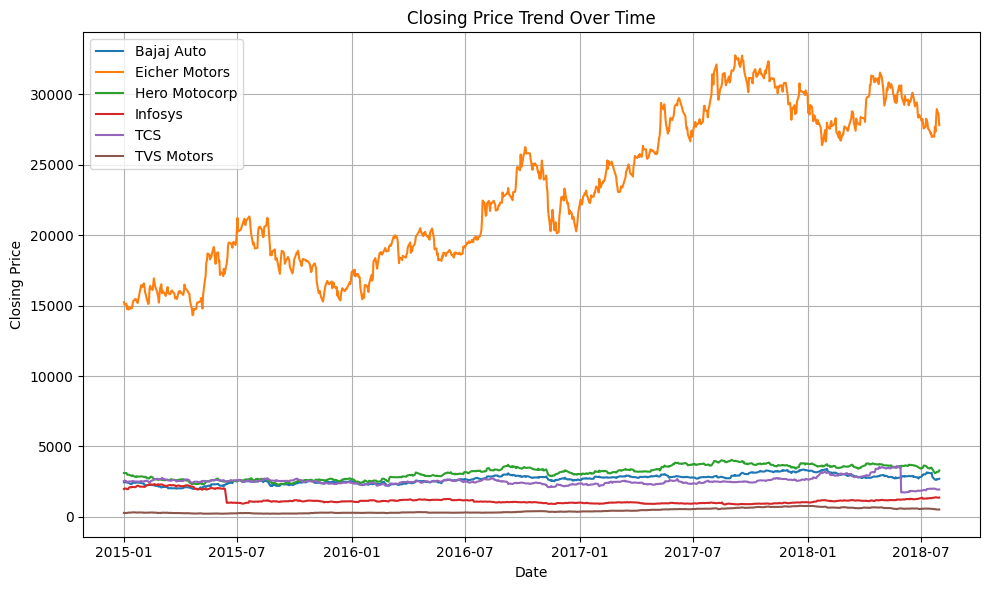

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for company, dfc in combined.groupby("company"):
    plt.plot(dfc["date"], dfc["close"], label=company)

plt.title("Closing Price Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


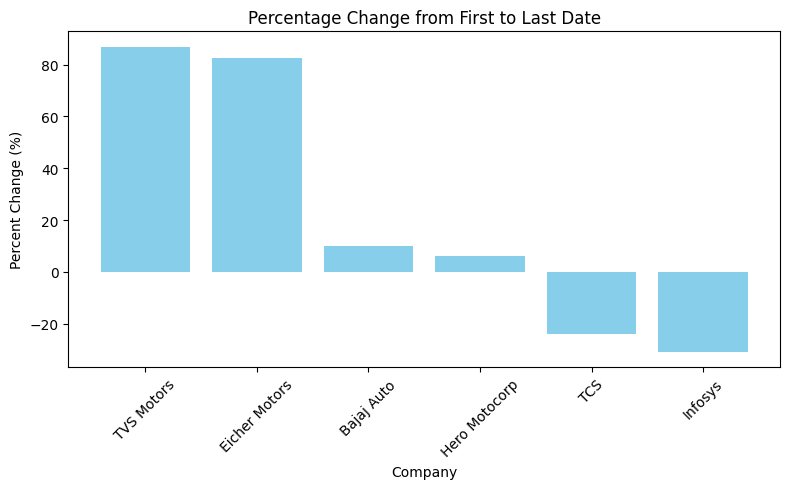

In [17]:
trend_df = results["trend_percentage_change"]

plt.figure(figsize=(8,5))
plt.bar(trend_df["company"], trend_df["percent_change"], color="skyblue")
plt.title("Percentage Change from First to Last Date")
plt.xlabel("Company")
plt.ylabel("Percent Change (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


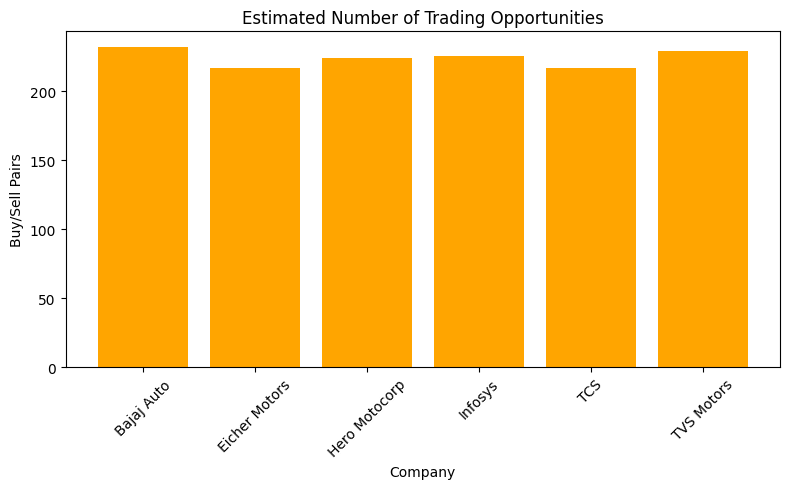

In [18]:
plt.figure(figsize=(8,5))
plt.bar(opportunities_df["company"], opportunities_df["buy_sell_pairs"], color="orange")
plt.title("Estimated Number of Trading Opportunities")
plt.xlabel("Company")
plt.ylabel("Buy/Sell Pairs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


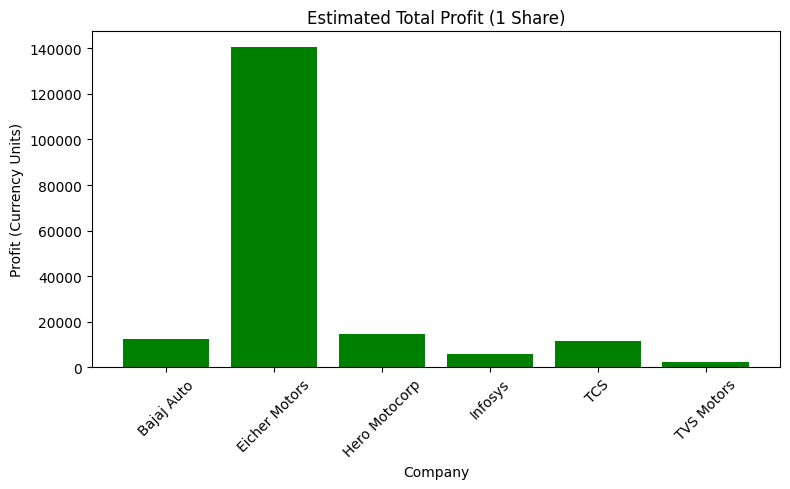

In [19]:
plt.figure(figsize=(8,5))
plt.bar(opportunities_df["company"], opportunities_df["gross_profit_if_1_share"], color="green")
plt.title("Estimated Total Profit (1 Share)")
plt.xlabel("Company")
plt.ylabel("Profit (Currency Units)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


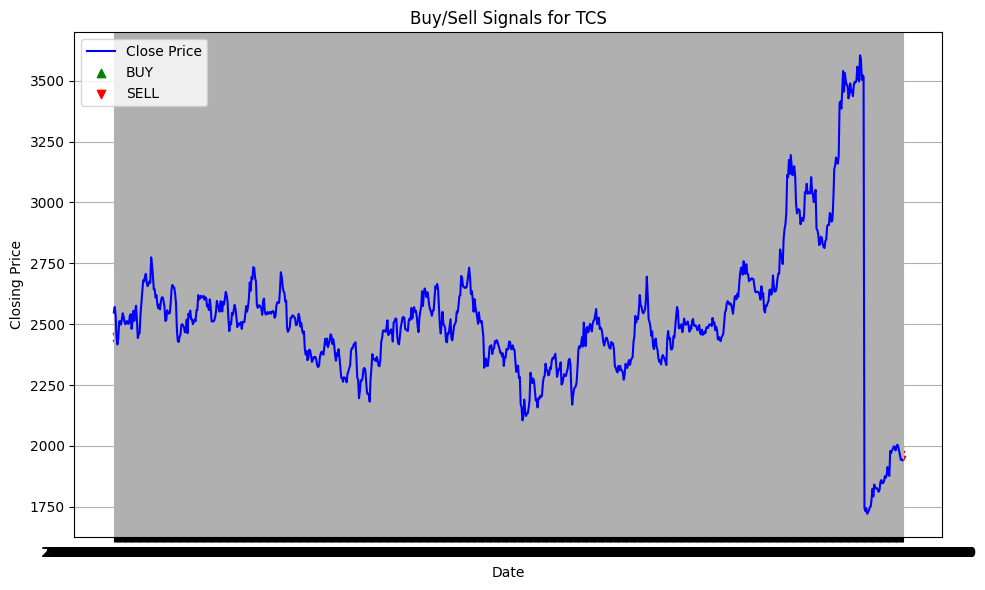

In [20]:
signals_df = results["buy_sell_signals"]
company_name = "TCS" 
df_signals = signals_df[signals_df["company"] == company_name]

plt.figure(figsize=(10,6))
plt.plot(df_signals["date"], df_signals["close"], label="Close Price", color="blue")
plt.scatter(df_signals[df_signals["signal"] == "BUY"]["date"], 
            df_signals[df_signals["signal"] == "BUY"]["close"], color="green", label="BUY", marker="^")
plt.scatter(df_signals[df_signals["signal"] == "SELL"]["date"], 
            df_signals[df_signals["signal"] == "SELL"]["close"], color="red", label="SELL", marker="v")

plt.title(f"Buy/Sell Signals for {company_name}")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6) Merge summary and export CSVs + PDF report

In [15]:

trend_df = results["trend_percentage_change"].copy()
maxmin_df = results["max_min_close"].copy()
latest_rec_df = results["latest_recommendation"].copy()

summary = trend_df.merge(maxmin_df, on="company", how="left")
summary = summary.merge(opportunities_df, on="company", how="left")
summary = summary.merge(latest_rec_df[["company","latest_date","latest_signal","recommendation","overall_percent_change"]],
                        on="company", how="left")

summary.to_csv(SUMMARY_CSV_PATH, index=False)
results["buy_sell_signals"].to_csv(SIGNALS_CSV_PATH, index=False)
opportunities_df.to_csv(OPPS_CSV_PATH, index=False)

summary


,company,start_date,end_date,start_close,end_close,percent_change,min_close,max_close,buy_sell_pairs,gross_profit_if_1_share,latest_date,latest_signal,recommendation,overall_percent_change
0,TVS Motors,2015-01-01 00:00:00,2018-07-31 00:00:00,276.85,517.45,86.91,213.55,785.3,229,2551.25,2018-07-31 00:00:00,HOLD,HOLD,86.91
1,Eicher Motors,2015-01-01 00:00:00,2018-07-31 00:00:00,15239.15,27820.95,82.56,14320.60,32786.4,217,140430.45,2018-07-31 00:00:00,SELL,HOLD,82.56
2,Bajaj Auto,2015-01-01 00:00:00,2018-07-31 00:00:00,2454.10,2700.70,10.05,1949.40,3409.5,232,12423.75,2018-07-31 00:00:00,HOLD,HOLD,10.05
3,Hero Motocorp,2015-01-01 00:00:00,2018-07-31 00:00:00,3107.30,3293.80,6.00,2279.80,4047.3,224,14494.85,2018-07-31 00:00:00,BUY,BUY,6.00
4,TCS,2015-01-01 00:00:00,2018-07-31 00:00:00,2548.20,1941.25,-23.82,1721.20,3604.8,217,11711.90,2018-07-31 00:00:00,HOLD,HOLD,-23.82
5,Infosys,2015-01-01 00:00:00,2018-07-31 00:00:00,1975.80,1365.00,-30.91,873.50,2326.6,226,6036.45,2018-07-31 00:00:00,HOLD,HOLD,-30.91
